In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/CFL_training_data"

# Load input and output images

In [ ]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(data_path, 'input'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'input', image)), (256,256)))
  output_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

# Building Unet by dividing encoder and decoder into blocks

In [ ]:

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build U^2net using the blocks
def u2_module(input_tensor, num_filters):
    # U² module consists of two conv blocks and a 1x1 convolution
    x = conv_block(input_tensor, num_filters)
    x = conv_block(x, num_filters)
    x = Conv2D(1, 1, padding="same", activation="sigmoid")(x)  # Output has 1 channel for binary segmentation
    return x

def build_u2net(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Add U² module
    u2_output = u2_module(d4, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(u2_output)

    model = Model(inputs, outputs, name="U2_Net")
    return model

# Create U²-Net model

In [ ]:
u2net_model = build_u2net((256, 256, 3), 1)

In [ ]:
u2net_model.summary()

Model: "U2_Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][

# Define IoU metric

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
u2net_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
np.array(output_images).shape

(500, 256, 256, 1)

# Define callbacks

In [ ]:
checkpoint_filepath = os.path.join(data_path, "{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Train the U²-Net model

In [ ]:
u2net_model.fit(x=np.array(input_images),
                y=np.array(output_images),
                validation_split=0.2,
                batch_size=8,
                epochs=30,
                verbose=1,  # Set verbose to 1 for progress updates during training
                callbacks=[model_checkpoint_callback],
                shuffle=True)  # Shuffle the data during training


Epoch 1/30
50/50 [==============================] - 79s 807ms/step - loss: -0.4523 - dice_coef: 0.4568 - binary_accuracy: 0.6662 - true_positive_rate: 0.0038 - val_loss: -0.3255 - val_dice_coef: 0.3318 - val_binary_accuracy: 0.6707 - val_true_positive_rate: 0.0000e+00
Epoch 2/30
50/50 [==============================] - 32s 636ms/step - loss: -0.4919 - dice_coef: 0.4960 - binary_accuracy: 0.7184 - true_positive_rate: 0.1721 - val_loss: -0.3067 - val_dice_coef: 0.3127 - val_binary_accuracy: 0.6707 - val_true_positive_rate: 0.0000e+00
Epoch 3/30
50/50 [==============================] - 33s 655ms/step - loss: -0.4938 - dice_coef: 0.4979 - binary_accuracy: 0.8953 - true_positive_rate: 0.7451 - val_loss: -0.3350 - val_dice_coef: 0.3407 - val_binary_accuracy: 0.6707 - val_true_positive_rate: 0.0000e+00
Epoch 4/30
50/50 [==============================] - 33s 668ms/step - loss: -0.4953 - dice_coef: 0.4993 - binary_accuracy: 0.9555 - true_positive_rate: 0.9466 - val_loss: -0.3991 - val_dice_coef

# Make predictions on training data

In [ ]:
train_predictions = u2net_model.predict(np.array(input_images))

# Visualize the first few predictions along with the corresponding ground truth

16/16 [==============================] - 50s 2s/step


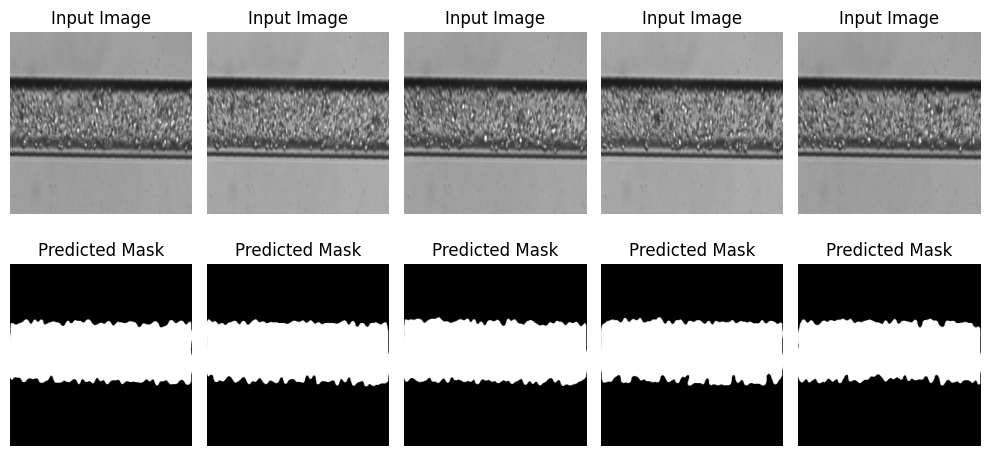

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(input_images[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(train_predictions[i][:, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

